In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import torch
import matplotlib.patches as patches
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
import numpy as np

## Step 1 : Build Costum data class

In [2]:
class BloodCellDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, csv_file, split, num_classes, num_bboxes):
        self.annotations = pd.read_csv(csv_file)
        self.dict_ = {"rbc":0, "wbc":1}
        self.annotations['label'] = self.annotations.label.map(self.dict_)
        self.img_dir = img_dir
        self.S = split
        self.C = num_classes
        self.B = num_bboxes
        
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __getitem__(self, index):
        ## image_name as parameter
        bboxes = []
        image_name = str(index)+".png"
        image_name_csv = "image-"+str(index)+".png"
        
        image = cv2.imread(os.path.join(self.img_dir,image_name))
        boxes = self.annotations[self.annotations["image"] == image_name_csv].drop(columns=["image"]).to_numpy()
        for box in boxes:
            xmin, ymin, xmax, ymax, class_label = float(box[1]), float(box[2]), float(box[3]), float(box[4]), box[5]
            x, y = ((xmin + xmax)/2)/image.shape[0], ((ymin + ymax)/2)/image.shape[1]
            width, height = abs(xmax - xmin)/image.shape[0], abs(ymax - ymin)/image.shape[1]
            bboxes.append([class_label, x,y,width,height]) 
        img = Image.open(os.path.join(self.img_dir,image_name))
        bboxes = torch.Tensor([x for x in bboxes])
        
        new_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        img = new_transform(img)
        
         ## label_matrix
        label_matrix = torch.zeros((self.S, self.S, self.C + self.B * 5 ))
        
        for box in bboxes:
            class_label, x, y, width, height = box.tolist()
            i, j = int(self.S*y), int(self.S*x)
            x_cell, y_cell = self.S * x - j, self.S * y - i  
            width_cell, height_cell = (                                                                                                                
                width * self.S,
                height * self.S
            )
                
            if label_matrix[i, j, 2] == 0:
                label_matrix[i,j,2] = 1
                label_matrix[i,j,3:7] = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                label_matrix[i,j,int(class_label)] = 1
        return img, label_matrix
    
    def __show_img_annotated__(self, index):
        img_file = str(index)+".png"
        img_file_csv =  "image-"+ str(index)+".png"
        image_path = os.path.join(self.img_dir,img_file)
        image_boxes = self.annotations[self.annotations["image"] == img_file_csv].drop(columns=["image"]).to_numpy()
        im = cv2.imread(image_path)
        
        for i in image_boxes:
            plt.plot([i[1],i[1],i[3],i[3],i[1]], [i[2],i[4],i[4],i[2],i[2]])
        plt.imshow(im)
        plt.show()
        new_transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((112, 112))])
        
        im = new_transform(im)


In [3]:
blood_cell_dataset =  BloodCellDataset("archive/images", "archive/annotation.csv", 7, 2, 1)

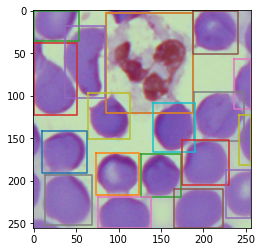

In [4]:
blood_cell_dataset.__show_img_annotated__(0)

## Step 3 : Utils Functions

In [5]:
def convert_cellboxes(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 7)
    best_boxes = predictions[..., 3:7]
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :2].argmax(-1).unsqueeze(-1)
    best_confidence = predictions[..., 2].unsqueeze(-1)
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )
    return converted_preds

def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []
    for ex_idx in range(out.shape[0]):
        bboxes = []
        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)
    return all_bboxes

def Intersection_over_union(boxes_preds, boxes_labels):
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def non_max_supression(bboxes,iou_threshold,threshold):
    assert type(bboxes) == list
    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []
    while bboxes:
        chosen_bbox = bboxes.pop(0)
        bboxes = [
                    box 
                    for box in bboxes
                    if box[0] != chosen_bbox[0]
                    or Intersection_over_union(
                    torch.tensor(chosen_bbox[2:]),
                    torch.tensor(box[2:])
                    ) < iou_threshold
                ]
        bboxes_after_nms.append(chosen_bbox)
    return bboxes_after_nms

def get_bboxes(loader, model, iou_threshold, threshold, pred_format="cells",device="cuda",):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_supression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, num_classes=20):
    average_precisions = []
    epsilon = 1e-6
    for c in range(num_classes):
        detections = []
        ground_truths = []
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        if total_true_bboxes == 0:
            continue
        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]
            num_gts = len(ground_truth_img)
            best_iou = 0
            for idx, gt in enumerate(ground_truth_img):
                iou = Intersection_over_union(torch.tensor(detection[3:]),torch.tensor(gt[3:]))
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))
    return sum(average_precisions) / len(average_precisions)

## Build Network

In [6]:
Model_architecture = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 512, 1, 1),
    "M",
    (3, 1024, 1, 1),
    (3, 1024, 1, 1)
]

In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.Leakyrelu = nn.LeakyReLU(0.001)
    def forward(self, x):
        return self.Leakyrelu(self.batchnorm(self.conv(x)))

In [8]:
class Net(nn.Module):
    def __init__(self, network_architecture, in_channels):
        super(Net, self).__init__()
        self.network_architecture = network_architecture
        self.in_channels = in_channels
        self.convLayers = self.convLayers_()
        
        self.fc1 = nn.Linear(7*7*1024, 1024)
        self.leakyrelu = nn.LeakyReLU(0.001)
        self.fc2 = nn.Linear(1024, 7*7*7)
        
    def convLayers_(self):
        layers = []
        for i in self.network_architecture:
            if type(i) == str:
                layers += [nn.MaxPool2d(2, stride=2)]
                
            elif type(i) == tuple:
                layers += [Block(self.in_channels, out_channels=i[1], kernel_size=i[0], stride=i[2], padding=i[3])]
                self.in_channels = i[1]
                
            elif type(i) == list:
                for _ in range(i[-1]):
                    layers += [Block(self.in_channels, out_channels=i[0][1], kernel_size=i[0][0], stride=i[0][2], padding=i[0][3])]
                    layers += [Block(in_channels=i[0][1], out_channels=i[1][1], kernel_size=i[1][0], stride=i[1][2], padding=i[1][3])]
                    self.in_channels = i[1][1]
        return nn.Sequential(*layers)

    
        
    def forward(self, x):
        x = self.convLayers(x)
        x = x.view(-1, 7*7*1024)
        x = self.fc1(x)
        x = self.leakyrelu(x)
        x = self.fc2(x) 
        return x

In [9]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=1, C=2):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
        exists_box = target[..., 2].unsqueeze(3)
        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #
        box_predictions = exists_box * predictions[..., 3:7]
        box_targets = exists_box * target[..., 3:7]
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
    
        box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2),torch.flatten(box_targets, end_dim=-2))
        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #
        pred_box = predictions[..., 2:3]
        object_loss = self.mse(torch.flatten(exists_box * pred_box),torch.flatten(exists_box * target[..., 2:3]))
        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        no_object_loss = self.mse(torch.flatten((1 - exists_box) * predictions[..., 2:3], start_dim=1),torch.flatten((1 - exists_box) * target[..., 2:3], start_dim=1),)
        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #
        class_loss = self.mse(torch.flatten(exists_box * predictions[..., :2], end_dim=-2,),torch.flatten(exists_box * target[..., :2], end_dim=-2,),)
        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )
        return loss

In [10]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [11]:
net = Net(network_architecture=Model_architecture, in_channels=3).to(device)

## Training

In [12]:
from collections import Counter

In [13]:
IMG_SIZE = 224
LEARNING_RATE = 2e-5
BATCH_SIZE = 1 # 64 in original paper
EPOCHS = 100

In [14]:
blood_cell_dataset =  BloodCellDataset("archive/images", "archive/annotation.csv", 7, 2, 1)
train_loader = DataLoader(
    dataset=blood_cell_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
loss_fn = YoloLoss()

In [15]:
map_res = []

In [16]:
for epoch in range(EPOCHS):  
    print("[INFO] EPOCH ", epoch)
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = net(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        net.zero_grad()
        loss.backward()
        optimizer.step()
        
    pred_boxes, target_boxes = get_bboxes(train_loader, net, iou_threshold=0.5, threshold=0.4)
    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5)
    map_res.append(mean_avg_prec)
    print(f"Train mAP: {mean_avg_prec}")
    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

[INFO] EPOCH  0


  3%|██▍                                                                               | 3/100 [00:00<00:06, 14.24it/s]

Train mAP: 0.04793097823858261
Mean loss was 86.73211572647095
[INFO] EPOCH  1


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.98it/s]

Train mAP: 0.10650768876075745
Mean loss was 28.07927221298218
[INFO] EPOCH  2


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.07026690244674683
Mean loss was 23.337379264831544
[INFO] EPOCH  3


  3%|██▍                                                                               | 3/100 [00:00<00:05, 18.74it/s]

Train mAP: 0.1226528212428093
Mean loss was 20.44177652359009
[INFO] EPOCH  4


  2%|█▋                                                                                | 2/100 [00:00<00:06, 16.17it/s]

Train mAP: 0.14420688152313232
Mean loss was 19.330764513015747
[INFO] EPOCH  5


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.20it/s]

Train mAP: 0.10386165976524353
Mean loss was 19.644561853408813
[INFO] EPOCH  6


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.97it/s]

Train mAP: 0.1168576255440712
Mean loss was 20.151689529418945
[INFO] EPOCH  7


  2%|█▋                                                                                | 2/100 [00:00<00:05, 18.40it/s]

Train mAP: 0.1541329324245453
Mean loss was 22.092064781188967
[INFO] EPOCH  8


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.197483092546463
Mean loss was 21.67763348579407
[INFO] EPOCH  9


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.26it/s]

Train mAP: 0.171518474817276
Mean loss was 21.228619976043703
[INFO] EPOCH  10


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.01it/s]

Train mAP: 0.16507062315940857
Mean loss was 22.871365995407103
[INFO] EPOCH  11


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.60it/s]

Train mAP: 0.20447096228599548
Mean loss was 20.837176094055177
[INFO] EPOCH  12


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.90it/s]

Train mAP: 0.22716593742370605
Mean loss was 19.237608747482298
[INFO] EPOCH  13


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.42it/s]

Train mAP: 0.27561837434768677
Mean loss was 19.193990564346315
[INFO] EPOCH  14


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.26it/s]

Train mAP: 0.2338603287935257
Mean loss was 19.98235689163208
[INFO] EPOCH  15


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.2765207886695862
Mean loss was 22.149810791015625
[INFO] EPOCH  16


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.22it/s]

Train mAP: 0.2567272484302521
Mean loss was 20.086165685653686
[INFO] EPOCH  17


  3%|██▍                                                                               | 3/100 [00:00<00:05, 18.71it/s]

Train mAP: 0.2670687437057495
Mean loss was 20.397955465316773
[INFO] EPOCH  18


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.97it/s]

Train mAP: 0.30259090662002563
Mean loss was 20.08070734977722
[INFO] EPOCH  19


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.59it/s]

Train mAP: 0.35177743434906006
Mean loss was 19.018032388687132
[INFO] EPOCH  20


  2%|█▋                                                                                | 2/100 [00:00<00:05, 17.74it/s]

Train mAP: 0.3521285057067871
Mean loss was 18.21150937080383
[INFO] EPOCH  21


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.68it/s]

Train mAP: 0.2947966158390045
Mean loss was 19.07972267150879
[INFO] EPOCH  22


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.98it/s]

Train mAP: 0.34072908759117126
Mean loss was 19.0466442489624
[INFO] EPOCH  23


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.90it/s]

Train mAP: 0.2716441750526428
Mean loss was 17.104308195114136
[INFO] EPOCH  24


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.64it/s]

Train mAP: 0.2874959111213684
Mean loss was 17.55573528766632
[INFO] EPOCH  25


  2%|█▋                                                                                | 2/100 [00:00<00:08, 12.15it/s]

Train mAP: 0.28998643159866333
Mean loss was 17.994876618385316
[INFO] EPOCH  26


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.19it/s]

Train mAP: 0.34843307733535767
Mean loss was 16.06401518344879
[INFO] EPOCH  27


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.52it/s]

Train mAP: 0.37620115280151367
Mean loss was 15.978792085647584
[INFO] EPOCH  28


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.97it/s]

Train mAP: 0.47136780619621277
Mean loss was 15.958265209197998
[INFO] EPOCH  29


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.00it/s]

Train mAP: 0.31434503197669983
Mean loss was 15.500366296768188
[INFO] EPOCH  30


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.12it/s]

Train mAP: 0.3912939429283142
Mean loss was 15.340388793945312
[INFO] EPOCH  31


  2%|█▋                                                                                | 2/100 [00:00<00:07, 12.64it/s]

Train mAP: 0.33751633763313293
Mean loss was 14.813899178504943
[INFO] EPOCH  32


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.57it/s]

Train mAP: 0.4195345342159271
Mean loss was 13.991128063201904
[INFO] EPOCH  33


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.11it/s]

Train mAP: 0.4131639301776886
Mean loss was 13.974598627090455
[INFO] EPOCH  34


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.99it/s]

Train mAP: 0.42229288816452026
Mean loss was 14.216016464233398
[INFO] EPOCH  35


  2%|█▋                                                                                | 2/100 [00:00<00:05, 16.66it/s]

Train mAP: 0.4486892819404602
Mean loss was 14.023319158554077
[INFO] EPOCH  36


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.5505247116088867
Mean loss was 12.81543254852295
[INFO] EPOCH  37


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.95it/s]

Train mAP: 0.5877211689949036
Mean loss was 11.63490786075592
[INFO] EPOCH  38


  3%|██▍                                                                               | 3/100 [00:00<00:05, 16.43it/s]

Train mAP: 0.585806131362915
Mean loss was 12.290110926628113
[INFO] EPOCH  39


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.09it/s]


Train mAP: 0.4312967360019684
Mean loss was 12.259413948059082
[INFO] EPOCH  40


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'archive/images'

## Test the Model predictions

In [ ]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(im)
    # Create a Rectangle potch
    for box in boxes:
        label = "rbc" if box[0] == 0 else "wbc"
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        center_x = upper_left_x * width + (box[2] * width)/2
        center_y = upper_left_y * height + (box[3] * height)/2
        plt.text(center_x, center_y, label, fontsize=9)

        ax.add_patch(rect)
    plt.show()

In [ ]:
for x, y in train_loader:
    x = x.to(device)
    bboxes = cellboxes_to_boxes(net(x))
    bboxes = non_max_supression(bboxes[0], iou_threshold=0.5, threshold=0.4)
    plot_image(x[0].permute(1,2,0).to("cpu"), bboxes)
    break